In [1]:
%load_ext autoreload
%autoreload 2 

* 이미지를 VAE로 Embedding하여 얻은 vector의 similarity와 풍속데이터의 Similarity 비교
* 체크해야 할 것
    - 풍속기록이 있는 데이터만 필요하며, 일부는 Train 일부는 test 이를 구분해야 할 필요가 있음

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict

import yaml
import torch
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, DataLoader, TensorDataset

from models import *
from src import *

In [3]:
# Wind data load

with open('../../Share_Data/windspeed/_Main_dataset.pickle', 'rb') as f:
    windspeed_dataset = pickle.load(f)
    
station_list = list(windspeed_dataset.keys())
windspeed_list = []
for item in windspeed_dataset.values():
    windspeed_list.append(item[3])
windspeed_list = np.array(windspeed_list)

In [4]:
# load config
config_path = 'configs/betatc_vae_sate.yaml'
checkpoint_path = '../../Share_Data/logs/BetaTCVAE_RGB/6e96a0d66be943d385b7f5d3e21d55bd/epoch=999.ckpt'

with open(config_path, 'rb') as f:
    config = yaml.safe_load(f)

#load vae model
model = vae_models[config['model_params']['name']](**config['model_params'])
untrained_model = vae_models[config['model_params']['name']](**config['model_params'])

#checkpoint load
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu')) # when using CPU
new_state_dict = OrderedDict()
for k, v in checkpoint['state_dict'].items():
    name = k[6:]
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [5]:
# load img data

IMG_PATH = '../../Share_Data/satellite/jpg_rgb_d10/_jpg_rgb_d10/{}.jpg'

img_list =[ ]
label_list = []
for station_code in station_list:
    img = Image.open(IMG_PATH.format(station_code)).resize([config['exp_params']['img_size']]*2)
    img_list.append(np.array(img))
    label_list.append(station_code)

img_list = (np.array(img_list)/255.)*2-1
tensor_img = torch.Tensor(img_list).permute(0,3,1,2)
tensor_dataset = TensorDataset(tensor_img)
dataloader = DataLoader(tensor_img)

In [6]:
x, y, mu, log_var, z = model.forward(tensor_img)
_, _, untrained_mu, untrained_log_var, untrained_z = untrained_model.forward(tensor_img)

print('size of latent vector, z : {}'.format(z.size()))

size of latent vector, z : torch.Size([349, 32])


---
### Test reconstruct

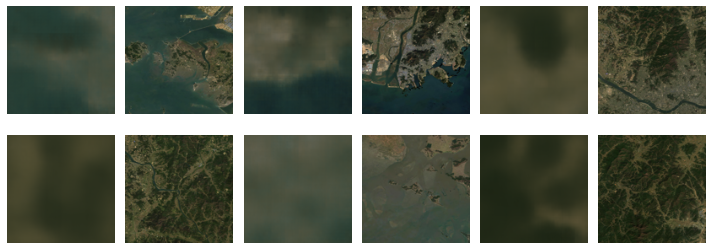

In [17]:
fig_num = 50
fig_num1 = 1
fig_num2 = 32
fig_num3 = 100
fig_num4 = 140
fig_num5 = 300

plt.figure(figsize=(10,4))

plt.subplot(2,6,1)
plt.imshow(((x[fig_num]+1)/2).permute(1,2,0).detach().numpy())
plt.axis('off')
plt.subplot(2,6,2)
plt.imshow(((y[fig_num]+1)/2).permute(1,2,0).detach().numpy())
plt.axis('off')

plt.subplot(2,6,3)
plt.imshow(((x[fig_num1]+1)/2).permute(1,2,0).detach().numpy())
plt.axis('off')
plt.subplot(2,6,4)
plt.imshow(((y[fig_num1]+1)/2).permute(1,2,0).detach().numpy())
plt.axis('off')

plt.subplot(2,6,5)
plt.imshow(((x[fig_num2]+1)/2).permute(1,2,0).detach().numpy())
plt.axis('off')
plt.subplot(2,6,6)
plt.imshow(((y[fig_num2]+1)/2).permute(1,2,0).detach().numpy())
plt.axis('off')

plt.subplot(2,6,7)
plt.imshow(((x[fig_num3]+1)/2).permute(1,2,0).detach().numpy())
plt.axis('off')
plt.subplot(2,6,8)
plt.imshow(((y[fig_num3]+1)/2).permute(1,2,0).detach().numpy())
plt.axis('off')

plt.subplot(2,6,9)
plt.imshow(((x[fig_num4]+1)/2).permute(1,2,0).detach().numpy())
plt.axis('off')
plt.subplot(2,6,10)
plt.imshow(((y[fig_num4]+1)/2).permute(1,2,0).detach().numpy())
plt.axis('off')

plt.subplot(2,6,11)
plt.imshow(((x[fig_num5]+1)/2).permute(1,2,0).detach().numpy())
plt.axis('off')
plt.subplot(2,6,12)
plt.imshow(((y[fig_num5]+1)/2).permute(1,2,0).detach().numpy())
plt.axis('off')



plt.tight_layout()
plt.show()

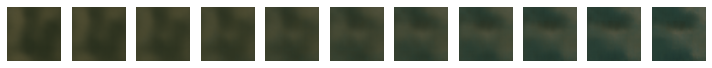

In [33]:
fig_num1 = 50
fig_num5 = 100

interpol_num = 10

z_num1 = z[fig_num1]
z_num5 = z[fig_num5]
z_diff = (z_num1 - z_num5)/interpol_num

plt.figure(figsize=(10,5))

for i in range(interpol_num+1):
    select_z = z_num5+z_diff*(i)
    recons = model.decode(select_z)
    plt.subplot(1, interpol_num+1, i+1)
    plt.imshow(((recons+1)/2)[0].permute(1,2,0).detach().numpy())
    plt.axis('off')
plt.tight_layout()
plt.show()

### Analysis

In [7]:
#windspeed difference matrix

windspeed_diff_list = []
for i in windspeed_list:
    temp_list = []
    for j in windspeed_list:
        temp_list.append(abs(i-j))
    windspeed_diff_list.append(temp_list)
windspeed_diff_list = np.array(windspeed_diff_list)

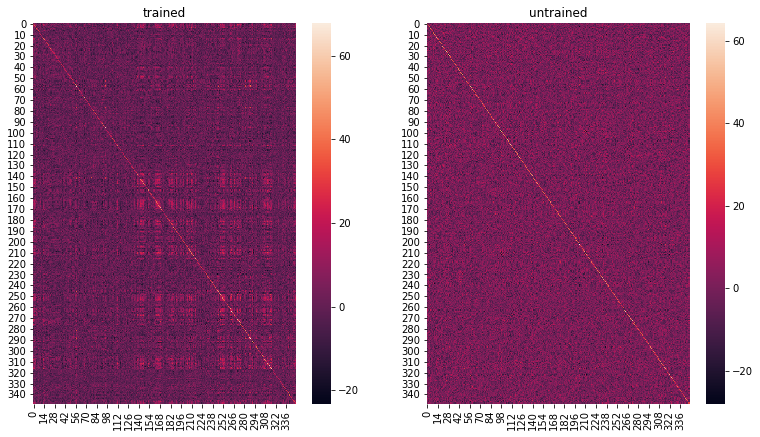

In [8]:
cov = torch.mm(z, z.t().contiguous())
untrained_cov = torch.mm(untrained_z, untrained_z.t().contiguous())

windspeed_diff = np.exp(-windspeed_diff_list/windspeed_diff_list.max()+1)


plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained')
sns.heatmap(cov.detach().numpy())

plt.subplot(1,3,2)
plt.title('untrained')
sns.heatmap(untrained_cov.detach().numpy())

#plt.subplot(1,3,3)
#plt.title('windspeed')
#sns.heatmap(windspeed_diff)
plt.show()

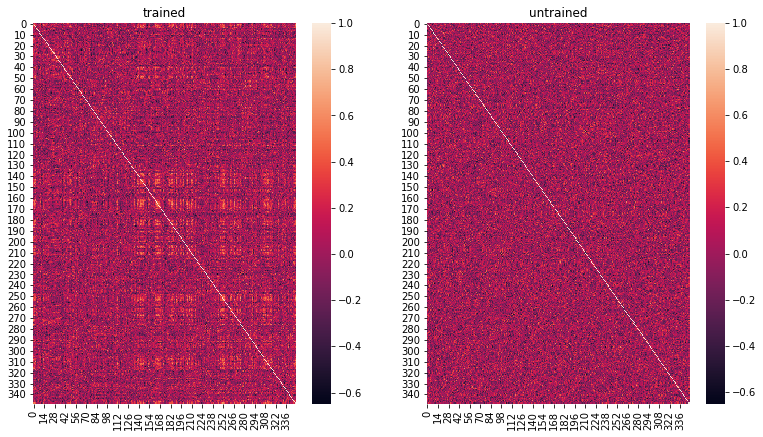

In [9]:
z_n = z.norm(dim=1)[:,None]
z_n = torch.max(z_n, 1e-8*torch.ones_like(z_n))

untrained_z_n = untrained_z.norm(dim=1)[:,None]
untrained_z_n = torch.max(untrained_z_n, 1e-8*torch.ones_like(untrained_z_n))

cov = torch.mm(z/z_n, (z/z_n).t().contiguous())
untrained_cov = torch.mm(untrained_z/untrained_z_n, (untrained_z/untrained_z_n).t().contiguous())

windspeed_diff = np.exp(-windspeed_diff_list/windspeed_diff_list.max()+1)


plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained')
sns.heatmap(cov.detach().numpy())

plt.subplot(1,3,2)
plt.title('untrained')
sns.heatmap(untrained_cov.detach().numpy())

#plt.subplot(1,3,3)
#plt.title('windspeed')
#sns.heatmap(windspeed_diff)
plt.show()

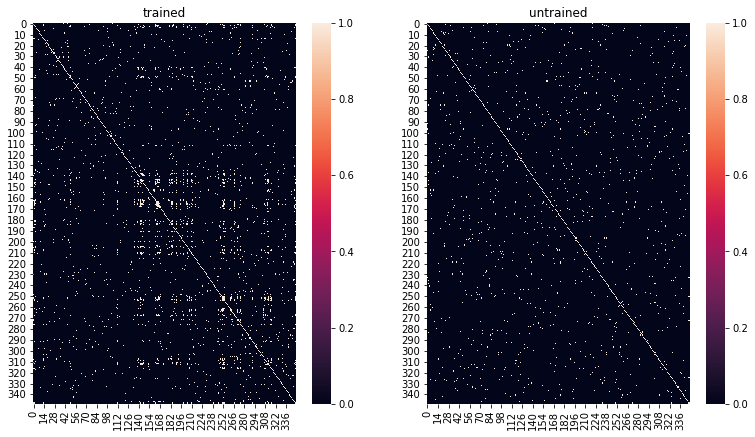

In [10]:
z_n = z.norm(dim=1)[:,None]
z_n = torch.max(z_n, 1e-8*torch.ones_like(z_n))

untrained_z_n = untrained_z.norm(dim=1)[:,None]
untrained_z_n = torch.max(untrained_z_n, 1e-8*torch.ones_like(untrained_z_n))

cov = torch.mm(z/z_n, (z/z_n).t().contiguous())
untrained_cov = torch.mm(untrained_z/untrained_z_n, (untrained_z/untrained_z_n).t().contiguous())

windspeed_diff = np.exp(-windspeed_diff_list/windspeed_diff_list.max()+1)


plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained')
sns.heatmap(cov.detach().numpy()>0.4)

plt.subplot(1,3,2)
plt.title('untrained')
sns.heatmap(untrained_cov.detach().numpy()>0.4)

#plt.subplot(1,3,3)
#plt.title('windspeed')
#sns.heatmap(windspeed_diff)
plt.show()

---
# REPORT

#### Index  
- [Report 1](#Report_1)
- [Report 2](#Report_2)
- [Report 3](#Report_3)

- [Experiment 1 ](#Experiment_1)

### Experiment_1
* 한번 latent_vector의 similarty를 기준으로 구해볼까...?

In [22]:
num_K = 5
cov_np = cov.detach().numpy()
similar_list = []
result = []

wind_select_f = lambda x : windspeed_list[x]
code_select_f = lambda x : list(windspeed_dataset)[x]

# 가중치 없이 그냥 평균
for i_index in range(len(station_list)):
    select_list = cov_np[i_index].argsort()[-1-num_K : -1]
    select_wind = list(map(wind_select_f, select_list))
    select_code = list(map(code_select_f, select_list))
    select_dic = dict(zip(select_code, select_wind))
    similar_list.append(select_dic)
    
    result.append(np.mean(select_wind))

3.7562794204557663
2.938200280400441


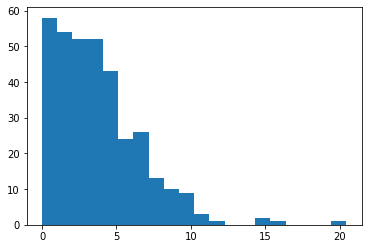

Except 10 : 3.4798481737800495
Except 20 : 3.3014070873531978


In [19]:
# --- k = 15
# --- Not distance Weight
# --- Just Mean

#plt.hist(windspeed_list-result, bins=20)
#print(np.mean(windspeed_list-result))
#print(np.std(windspeed_list-result))
#plt.show()

data = np.abs(windspeed_list-result)

plt.hist(data, bins=20)
print(np.mean(data))
print(np.std(data))
plt.show()

# Except 10
N = 10
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print('Except 10 : {}'.format(np.mean(_test)))

# Except 20
N = 20
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print('Except 20 : {}'.format(np.mean(_test)))

In [24]:
# distance weight sum

import geopy.distance as gedistc

weight_result = []

for i_index, (to_code, to_dic) in enumerate(windspeed_dataset.items()):
    to_place = to_dic[:2]
    distance_list = []
    for j_index in similar_list[i_index]:
        from_place = windspeed_dataset[j_index][:2]
        distance_list.append(1/gedistc.distance(to_place, from_place).km) 
    weight_windspeed = sum(np.array(list(similar_list[i_index].values())) * np.array(distance_list))
    weight_result.append(weight_windspeed/sum(distance_list))

3.5596548962101116
2.9100923176997666


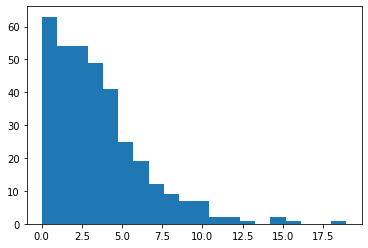

Except 10 : 3.2749955064408507
Except 20 : 3.081569105702131


In [21]:
# --- k = 15
# --- apply distance Weight

#plt.hist(windspeed_list-weight_result, bins=20)
#print(np.mean(windspeed_list-weight_result))
#print(np.std(windspeed_list-weight_result))
#plt.show()

data = np.abs(windspeed_list-weight_result)

plt.hist(data, bins=20)
print(np.mean(data))
print(np.std(data))
plt.show()

# Except 10
N = 10
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print('Except 10 : {}'.format(np.mean(_test)))

# Except 20
N = 20
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print('Except 20 : {}'.format(np.mean(_test)))

4.012963162649289
3.1687143348034623


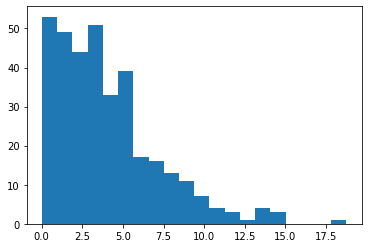

Except 10 : 3.714206363465622
Except 20 : 3.507221902201174


In [23]:
# --- k = 5!
# --- Not distance Weight
# --- Just Mean

#plt.hist(windspeed_list-result, bins=20)
#print(np.mean(windspeed_list-result))
#print(np.std(windspeed_list-result))
#plt.show()

data = np.abs(windspeed_list-result)

plt.hist(data, bins=20)
print(np.mean(data))
print(np.std(data))
plt.show()

# Except 10
N = 10
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print('Except 10 : {}'.format(np.mean(_test)))

# Except 20
N = 20
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print('Except 20 : {}'.format(np.mean(_test)))

4.008111063931702
3.124687376684122


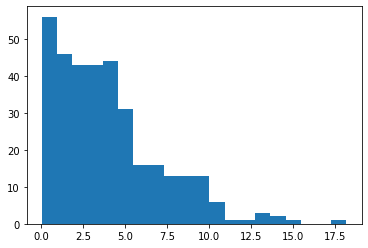

Except 10 : 3.7282942145855333
Except 20 : 3.5357804953001217


In [25]:
# --- k = 5
# --- apply distance Weight

#plt.hist(windspeed_list-weight_result, bins=20)
#print(np.mean(windspeed_list-weight_result))
#print(np.std(windspeed_list-weight_result))
#plt.show()

data = np.abs(windspeed_list-weight_result)

plt.hist(data, bins=20)
print(np.mean(data))
print(np.std(data))
plt.show()

# Except 10
N = 10
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print('Except 10 : {}'.format(np.mean(_test)))

# Except 20
N = 20
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print('Except 20 : {}'.format(np.mean(_test)))

---
### Report_1
* 66번 인덱스와 39번 인덱스 차이 비교|

In [33]:
a_index = 66
b_index = 39

In [34]:
# z list
select_value = []
select_value.append(z[a_index].detach().numpy())
select_value.append(z[b_index].detach().numpy())

# origin
img_a = img_list[a_index][0]
img_b = img_list[b_index][0]

# recons 
recons_img_a = model.decode(z[a_index]).detach().numpy()[0][0]
recons_img_b = model.decode(z[b_index]).detach().numpy()[0][0]

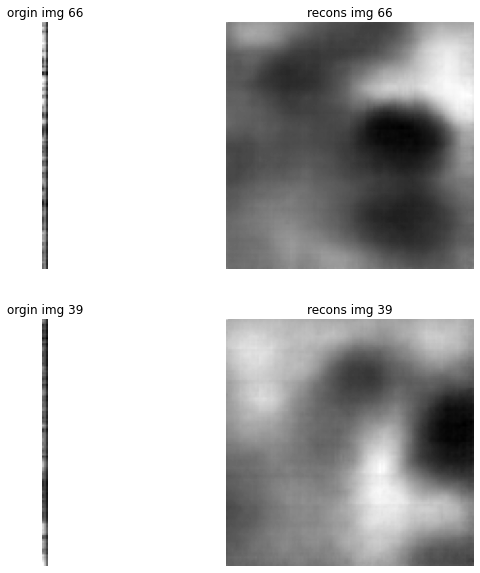

In [35]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(img_a, cmap='gray')
plt.title('orgin img {}'.format(a_index))
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(recons_img_a, cmap='gray')
plt.title('recons img {}'.format(a_index))
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(img_b, cmap='gray')
plt.title('orgin img {}'.format(b_index))
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(recons_img_b, cmap='gray')
plt.title('recons img {}'.format(b_index))
plt.axis('off')

plt.show()

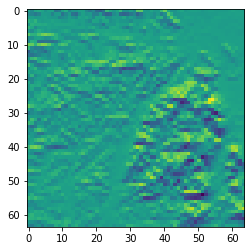

In [34]:
plt.imshow(img_list[66][0], cmap='gray')

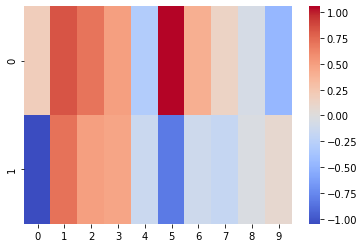

In [27]:
sns.heatmap(select_value, cmap='coolwarm')
plt.show()

---
### Report_2 
* 596(인덱스 104) 과 593(101) 비교

In [25]:
a_index = 104
b_index = 101

In [47]:
# z list
select_value = []
select_value.append(z[a_index].detach().numpy())
select_value.append(z[b_index].detach().numpy())

# origin
img_a = (img_list[a_index]+1)/2
img_b = (img_list[b_index]+1)/2

# recons 
recons_img_a = (model.decode(z[a_index]).permute(0,2,3,1).detach().numpy()[0]+1)/2
recons_img_b = (model.decode(z[b_index]).permute(0,2,3,1).detach().numpy()[0]+1)/2

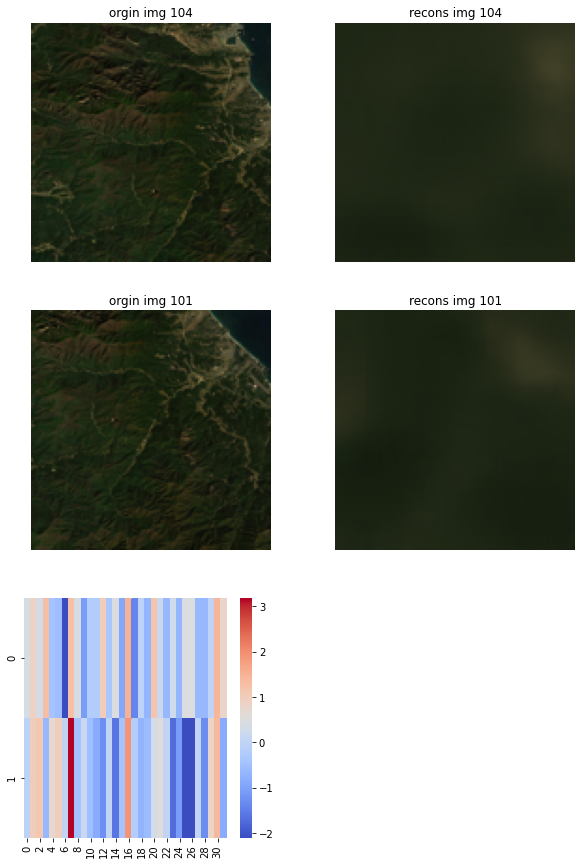

In [51]:
plt.figure(figsize=(10,15))

plt.subplot(3,2,1)
plt.imshow(img_a)
plt.title('orgin img {}'.format(a_index))
plt.axis('off')

plt.subplot(3,2,2)
plt.imshow(recons_img_a)
plt.title('recons img {}'.format(a_index))
plt.axis('off')

plt.subplot(3,2,3)
plt.imshow(img_b)
plt.title('orgin img {}'.format(b_index))
plt.axis('off')

plt.subplot(3,2,4)
plt.imshow(recons_img_b)
plt.title('recons img {}'.format(b_index))
plt.axis('off')

plt.subplot(3,2,5)
sns.heatmap(select_value, cmap='coolwarm')
plt.show()

* 비슷한만큼 vector도 비슷....

<AxesSubplot:>

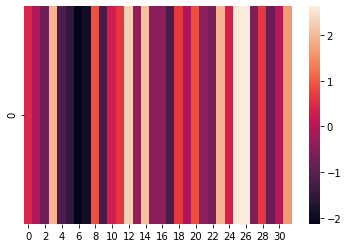

In [57]:
sns.heatmap((select_value[0]-select_value[1]).reshape(1,-1))

---
# Report_3
* 294(인덱스 347)
* 162(309)
* 909(251)
* 918(259)
* 921(262)

In [90]:
a_index = 347
b_index = 309
c_index = 251
d_index = 259
e_index = 262

In [151]:
# z list
select_value = []
select_value.append(z[a_index].detach().numpy())
select_value.append(z[b_index].detach().numpy())
select_value.append(z[c_index].detach().numpy())
select_value.append(z[d_index].detach().numpy())
select_value.append(z[e_index].detach().numpy())

# origin
img_a = (img_list[a_index]+1)/2
img_b = (img_list[b_index]+1)/2
img_c = (img_list[c_index]+1)/2
img_d = (img_list[d_index]+1)/2
img_e = (img_list[e_index]+1)/2

# recons 
recons_img_a = (model.decode(z[a_index]).permute(0,2,3,1).detach().numpy()[0]+1)/2
recons_img_b = (model.decode(z[b_index]).permute(0,2,3,1).detach().numpy()[0]+1)/2
recons_img_c = (model.decode(z[c_index]).permute(0,2,3,1).detach().numpy()[0]+1)/2
recons_img_d = (model.decode(z[d_index]).permute(0,2,3,1).detach().numpy()[0]+1)/2
recons_img_e = (model.decode(z[e_index]).permute(0,2,3,1).detach().numpy()[0]+1)/2

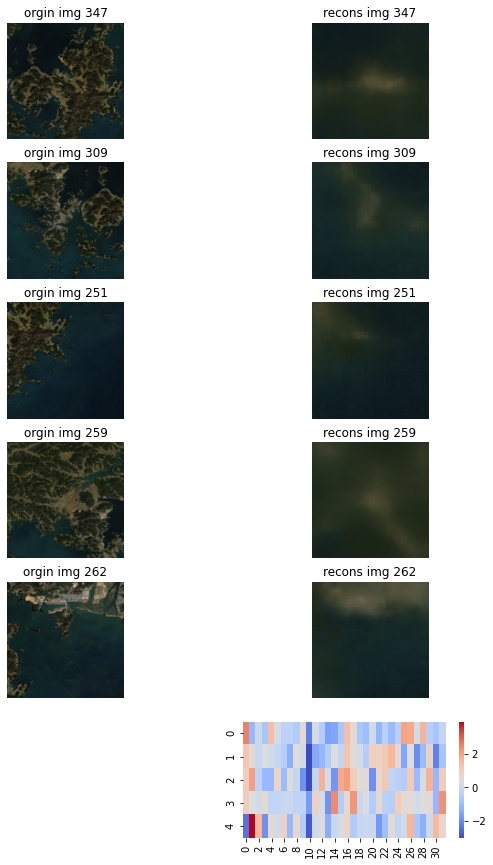

In [99]:
plt.figure(figsize=(10,15))

plt.subplot(6,2,1)
plt.imshow(img_a)
plt.title('orgin img {}'.format(a_index))
plt.axis('off')

plt.subplot(6,2,2)
plt.imshow(recons_img_a)
plt.title('recons img {}'.format(a_index))
plt.axis('off')

plt.subplot(6,2,3)
plt.imshow(img_b)
plt.title('orgin img {}'.format(b_index))
plt.axis('off')

plt.subplot(6,2,4)
plt.imshow(recons_img_b)
plt.title('recons img {}'.format(b_index))
plt.axis('off')

plt.subplot(6,2,5)
plt.imshow(img_c)
plt.title('orgin img {}'.format(c_index))
plt.axis('off')

plt.subplot(6,2,6)
plt.imshow(recons_img_c)
plt.title('recons img {}'.format(c_index))
plt.axis('off')

plt.subplot(6,2,7)
plt.imshow(img_d)
plt.title('orgin img {}'.format(d_index))
plt.axis('off')

plt.subplot(6,2,8)
plt.imshow(recons_img_d)
plt.title('recons img {}'.format(d_index))
plt.axis('off')

plt.subplot(6,2,9)
plt.imshow(img_e)
plt.title('orgin img {}'.format(e_index))
plt.axis('off')

plt.subplot(6,2,10)
plt.imshow(recons_img_e)
plt.title('recons img {}'.format(e_index))
plt.axis('off')

plt.subplot(6,2,12)
sns.heatmap(select_value, cmap='coolwarm')
plt.show()

* 음....
* 한번 5개의 Similarity을 보자

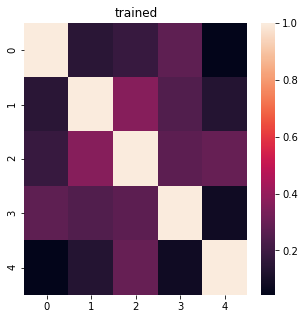

In [163]:
v_tensor = torch.tensor(select_value)

z_n = v_tensor.norm(dim=1)[:,None]
z_n = torch.max(z_n, 1e-8*torch.ones_like(z_n))

cov = torch.mm(v_tensor/z_n, (v_tensor/z_n).t().contiguous())

plt.figure(figsize=(5,5))
plt.title('trained')
sns.heatmap(cov.detach().numpy())

plt.show()

* 그럼 한번 Vector에서 둘이 비슷한 것을 찾아보자

In [149]:
(cov.detach().numpy()[a_index]).argsort()[-2]

314

In [112]:
cov.detach().numpy()[a_index, 314]

0.5335212

In [124]:
list(windspeed_dataset)[314]

'184'

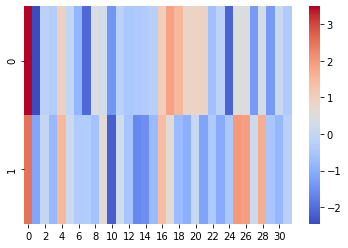

In [150]:
a_z = z[314].detach().numpy().reshape(1,-1)
b_z = z[347].detach().numpy().reshape(1,-1)
total_z = np.concatenate([a_z, b_z], axis=0)

sns.heatmap(total_z, cmap='coolwarm')
plt.show()

* Vector는 가장 비슷하나... 실제 이미지에서는..
* 이거 현재 Trained VAE의 한계인가! Simclr에서 보자